In [1]:
import yfinance as yf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [11]:
## Download Stock Data

stockTicker = yf.Ticker('ADANIPOWER.NS')
stockInfo = stockTicker.info
stocks = stockTicker.history(period="3y")

In [12]:
stocks['Average'] = stocks[['Open', 'High', 'Low', 'Close']].mean(numeric_only=True, axis=1)

In [13]:
stocks

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Average
Date,,,,,,,,
2020-10-13 00:00:00+05:30,36.049999,36.400002,36.049999,36.200001,733045,0,0,36.175000
2020-10-14 00:00:00+05:30,36.150002,36.549999,35.950001,36.099998,1180665,0,0,36.187500
2020-10-15 00:00:00+05:30,36.049999,36.799999,36.049999,36.099998,1100235,0,0,36.249999
2020-10-16 00:00:00+05:30,36.200001,36.349998,35.900002,36.000000,440489,0,0,36.112500
2020-10-19 00:00:00+05:30,36.099998,36.349998,35.299999,35.650002,923879,0,0,35.849999
...,...,...,...,...,...,...,...,...
2023-10-09 00:00:00+05:30,352.299988,355.000000,339.000000,342.000000,7353001,0,0,347.074997
2023-10-10 00:00:00+05:30,343.399994,352.799988,343.299988,349.649994,3720710,0,0,347.287491
2023-10-11 00:00:00+05:30,353.000000,358.700012,348.149994,349.799988,3488974,0,0,352.412498


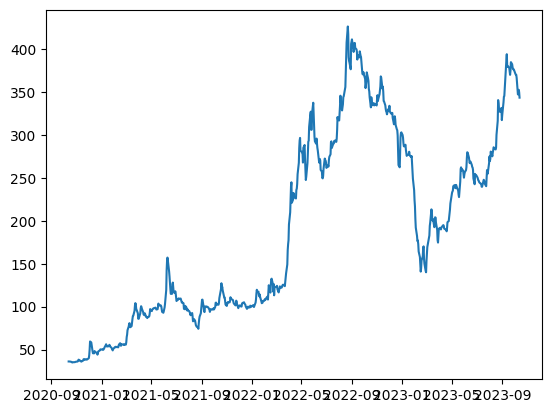

In [14]:
plt.plot(stocks['Average'])

In [15]:
## Class to calculate Stock Indicators

class StockIndicators:
    def __init__(self, df):
        self.sma_span = 10
        self.macd_slow = 14
        self.macd_fast = 28
        self.rsi_span = 14
        self.mfi_span = 14
        self.BollingerBands_span = 14
        self.df = df.drop(columns=['Dividends', 'Stock Splits'])
        
    def getSMA(self, span=None):
        if span != None:
            self.sma_span = span
        
        self.df['SMA'] = self.df['Average'].rolling(self.sma_span).mean()
        #return self.df
        
    def getMACD(self, fast=None, slow=None):
        if fast != None:
            self.macd_fast = fast
        if slow != None:
            self.macd_slow = slow
            
        exp1 = self.df['Average'].ewm(span = self.macd_fast, adjust = False).mean()
        exp2 = self.df['Average'].ewm(span = self.macd_slow, adjust = False).mean()
        self.df['MACD'] = exp1 - exp2
        
        #return self.df
        
    def getRSI(self, span=None):
        if span!=None:
            self.rsi_span = span
            
        ret = self.df['Average'].diff()
        up = []
        down = []
        for i in range(len(ret)):
            if ret[i] < 0:
                up.append(0)
                down.append(ret[i])
            else:
                up.append(ret[i])
                down.append(0)
        up_series = pd.Series(up)
        down_series = pd.Series(down).abs()
        up_ewm = up_series.ewm(com = self.rsi_span - 1, adjust = False).mean()
        down_ewm = down_series.ewm(com = self.rsi_span - 1, adjust = False).mean()
        rs = up_ewm/down_ewm
        rsi = 100 - (100 / (1 + rs))
        rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(self.df['Average'].index)
        self.df['RSI'] = rsi_df
        
        #return self.df
    
    def getMFI(self, span=None):
        if span!=None:
            self.mfi_span = span
            
        moneyFlow = self.df['Average'] * self.df['Volume']
        positive_flow = []
        negative_flow = []

        # Loop through the typical price
        for i in range(1, len(self.df['Average'])):
            if self.df['Average'][i] > self.df['Average'][i-1]:
                positive_flow.append(moneyFlow[i-1])
                negative_flow.append(0)

            elif self.df['Average'][i] < self.df['Average'][i-1]:
                negative_flow.append(moneyFlow[i-1])
                positive_flow.append(0)

            else:
                positive_flow.append(0)
                negative_flow.append(0)
                
        # Get all of the positive and negative money flows within the time period

        positive_mf = []
        negative_mf = []

        for i in range(self.mfi_span-1, len(positive_flow)):
            positive_mf.append( sum(positive_flow[i + 1- self.mfi_span : i+1]))

        for i in range(self.mfi_span-1, len(negative_flow)):
            negative_mf.append( sum(negative_flow[i + 1- self.mfi_span : i+1]))
            
        # Calculate the money flow index
        MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
        self.df['MFI'] = np.nan
        self.df['MFI'][self.mfi_span:] =  MFI
        
    def getBollingerBands(self, span=False):
        if span != False:
            self.BollingerBands_span = span
        
        self.df[f'SMA_{self.BollingerBands_span}'] = self.df['Average'].rolling(self.BollingerBands_span).mean()
        std = self.df['Average'].rolling(window = self.BollingerBands_span).std()
        self.df['UpperBB'] = self.df[f'SMA_{self.BollingerBands_span}'] + 2*std
        self.df['LowerBB'] = self.df[f'SMA_{self.BollingerBands_span}'] - 2*std
        


In [16]:
a = StockIndicators(stocks)
a.getMACD()
a.getSMA()
a.getRSI()
a.getMFI()
a.getBollingerBands()
a.df = a.df.dropna()

/tmp/ipykernel_1537013/2421384390.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['MFI'][self.mfi_span:] =  MFI


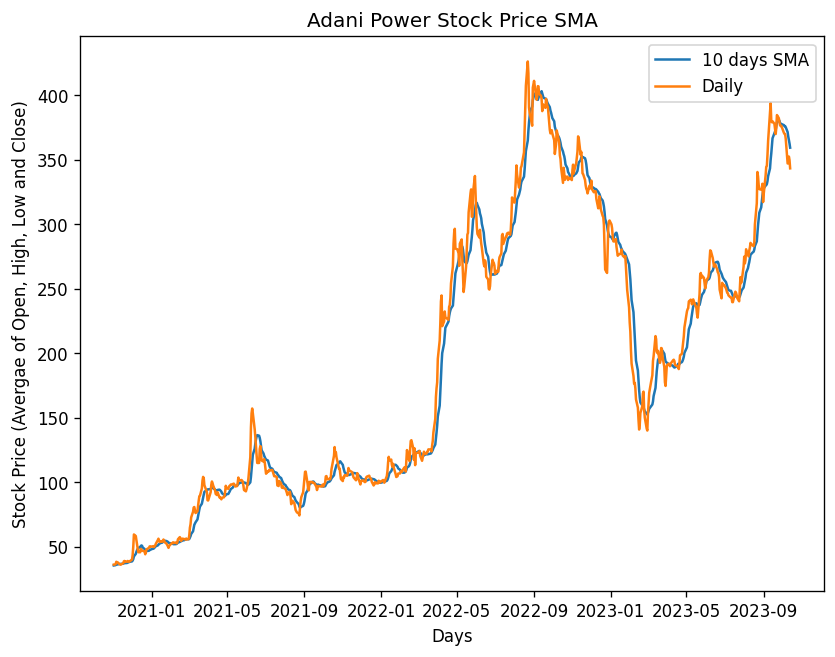

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=120)

plt.plot(a.df.index, a.df['SMA'])
plt.plot(a.df.index, a.df['Average'])
plt.legend(['10 days SMA', 'Daily'])
plt.xlabel("Days")
plt.ylabel("Stock Price (Avergae of Open, High, Low and Close)")
plt.title("Adani Power Stock Price SMA")
plt.savefig("Adani Power.png")

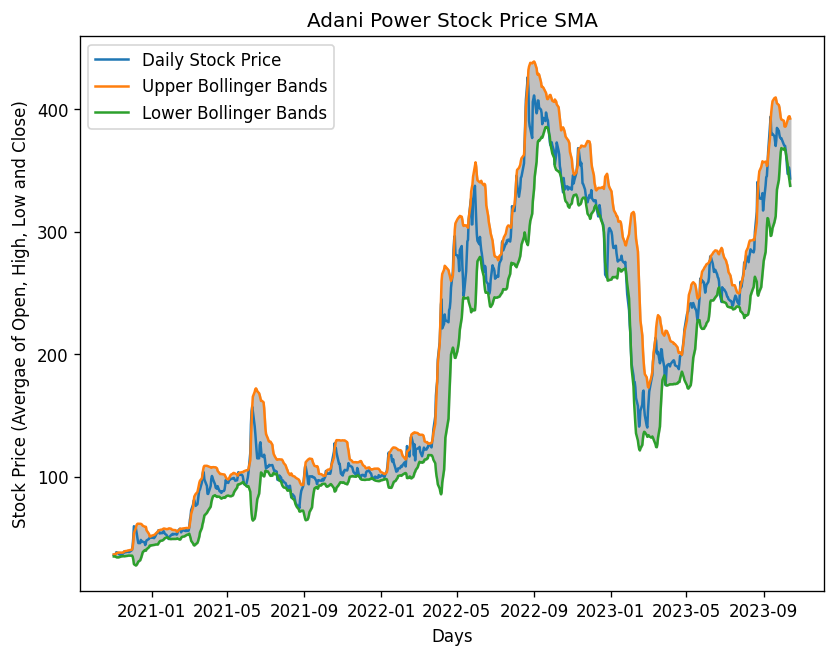

In [18]:
figure(figsize=(8, 6), dpi=120)

plt.plot(a.df.index, a.df['Average'])
plt.plot(a.df.index, a.df['UpperBB'])
plt.plot(a.df.index, a.df['LowerBB'])
plt.fill_between(a.df.index, a.df['UpperBB'], a.df['LowerBB'], color='silver')
plt.legend(['Daily Stock Price', 'Upper Bollinger Bands', 'Lower Bollinger Bands'])
plt.xlabel("Days")
plt.ylabel("Stock Price (Avergae of Open, High, Low and Close)")
plt.title("Adani Power Stock Price SMA")
plt.savefig("Adani Power_BB.png")